Springboard Capstone 02
## Predicting energy prices based on weather data in Spain
#### 01 - Data Wrangling
---

### Table of Contents<a id='Table_of_Contents'></a>
* [1.0 Energy Data Set](#1.0_energy_data_set)
  * [1.1 Import and inspect data](#1.1_Import_and_inspect_data)
    * [1.1.1 Checking datatypes](#1.1.1_Checking_datatypes)
    * [1.1.2 Convert time to datetime because parsing didn't work](#1.1.2_Convert_time_to_datetime)
    * [1.1.3 Create y-data profile report](#1.1.3_Create_y-data_profile_report)
    * [1.1.4 Set datetime as index](#1.1.4_Set_datetime_as_index)
  * [1.2 Investigating missing values in energy data](#1.2_Investigating_missing_values_in_energy_data)
    * [1.2.1 Generate information about missing data](#1.2.1_Generate_information_about_missing_data)
    * [1.2.2 Drop columns with too much missing information or only zeros](#1.2.2_Drop_columns)
    * [1.2.3 Investigate if total load actual is the sum of the generation columns](#1.2.3_Investigate_total_load)
  * [1.3 Summarizing and adding features](#1.3_Summarizing_adding)
    * [1.3.1 Implement total generation and difference calculations for entire dataframe](#1.3.1_Implement_total_generation)
    * [1.3.2 Summarize generation data using max](#1.3.2_Summarize_generation)
    * [1.3.3 Add month and day of week columns](#1.3.3_Add_month_and_day_of_week)
* [2.0 Weather Data Set](#2.0_Weather_Data_Set)
  * [2.1 Import and inspect data](#2.1_Import_and_inspect_data)
    * [2.1.1 Check to see the relationship between temp, temp_min, and temp_max](#2.1.1_Check_relationship_temp)
    * [2.1.2 Create y-data report](#2.1.2_Create_y-data_report)
    * [2.1.3 Check to see if the energy_data and weather_data have the same number of rows](#2.1.3_Check_num_rows)
  * [2.2 Investigate missing values in weather data](#2.2_Investigate_missing_values)
  * [2.3 Investigate categorical features](#2.3_Investigate_categorical_features)
  * [2.4 Summarizing the data](#2.4_Summarizing_the_data)

In [159]:
#Import libraries
import pandas as pd
import numpy as np
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil import tz
from pytz import timezone
import missingno as msno

## 1.0 Energy Data Set<a id='1.0_energy_data_set'></a>

### 1.1 Import and inspect data<a id='1.1_Import_and_inspect_data'></a> 

In [160]:
energy_data = pd.read_csv('raw_data/energy_dataset.csv', parse_dates=['time'])

In [161]:
energy_data.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


#### 1.1.1 Checking datatypes<a id='1.1.1_Checking_datatypes'></a>

In [162]:
energy_data.dtypes

time                                            object
generation biomass                             float64
generation fossil brown coal/lignite           float64
generation fossil coal-derived gas             float64
generation fossil gas                          float64
generation fossil hard coal                    float64
generation fossil oil                          float64
generation fossil oil shale                    float64
generation fossil peat                         float64
generation geothermal                          float64
generation hydro pumped storage aggregated     float64
generation hydro pumped storage consumption    float64
generation hydro run-of-river and poundage     float64
generation hydro water reservoir               float64
generation marine                              float64
generation nuclear                             float64
generation other                               float64
generation other renewable                     float64
generation

#### 1.1.2 Convert time to DateTime because parsing did not work<a id='1.1.2_Convert_time_to_datetime'></a>

In [163]:
#Need to use to_datetime to convert time to datetime, and have to set utc=True because there is DST and it won't work otherwise, however, after conversion, the times are now in UTC instead of local time.
energy_data['time'] = pd.to_datetime(energy_data['time'], utc=True)

In [164]:
#Convert to Madrid timezone
energy_data.time = energy_data.time.dt.tz_convert('Europe/Madrid')

In [165]:
energy_data.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


In [166]:
#Review summary of data
energy_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 29 columns):
 #   Column                                       Non-Null Count  Dtype                        
---  ------                                       --------------  -----                        
 0   time                                         35064 non-null  datetime64[ns, Europe/Madrid]
 1   generation biomass                           35045 non-null  float64                      
 2   generation fossil brown coal/lignite         35046 non-null  float64                      
 3   generation fossil coal-derived gas           35046 non-null  float64                      
 4   generation fossil gas                        35046 non-null  float64                      
 5   generation fossil hard coal                  35046 non-null  float64                      
 6   generation fossil oil                        35045 non-null  float64                      
 7   generation fossil oil 

#### 1.1.3 Create y-data profile report<a id='1.1.3_Create_y-data_profile_report'></a>

In [167]:
#Create y-data profile report
#profile_report = energy_data.profile_report(html={"style": {"full_width": True}})
#profile_report.to_file("Capstone02_ydatareport.html")

#### 1.1.4 Set datetime as index<a id='1.1.4_Set_datetime_as_index'></a>

In [168]:
energy_data.set_index('time', inplace=True)

### 1.2 Investigating missing values in energy data<a id='1.2_Investigating_missing_values_in_energy_data'></a>

#### 1.2.1 Generate information about missing data<a id='1.2.1_Generate_information_about_missing_data'></a>

In [169]:
#Analyze missing data in energy df
missing_energy = pd.concat([energy_data.isna().sum(), 100 * energy_data.isna().mean()], axis=1)
missing_energy.columns=['count', '%']
missing_energy.sort_values(by='count', ascending=False)

,count,%
generation hydro pumped storage aggregated,35064,100.000000
forecast wind offshore eday ahead,35064,100.000000
total load actual,36,0.102669
generation waste,19,0.054187
generation marine,19,0.054187
generation hydro pumped storage consumption,19,0.054187
generation biomass,19,0.054187
generation fossil oil,19,0.054187
generation hydro run-of-river and poundage,19,0.054187
generation fossil peat,18,0.051335


In [170]:
energy_data[energy_data['total load actual'].isna()]

,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
time,,,,,,,,,,,,,,,,,,,,,
2015-01-05 12:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3932.0,NaN,9258.0,23209.0,NaN,35.50,79.14
2015-01-05 13:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,4236.0,NaN,9156.0,23725.0,NaN,36.80,73.95
2015-01-05 14:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,4215.0,NaN,9072.0,23614.0,NaN,32.50,71.93
2015-01-05 15:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,4050.0,NaN,8779.0,22381.0,NaN,30.00,71.50
2015-01-05 16:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3728.0,NaN,8426.0,21371.0,NaN,30.00,71.85
2015-01-05 17:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3175.0,NaN,7946.0,20760.0,NaN,30.60,80.53
2015-01-28 13:00:00+01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,4136.0,NaN,6223.0,36239.0,NaN,65.00,77.62
2015-02-01 07:00:00+01:00,449.0,312.0,0.0,4765.0,5269.0,222.0,0.0,0.0,0.0,NaN,...,208.0,0.0,3289.0,18.0,NaN,3141.0,24379.0,NaN,56.10,16.98
2015-02-01 08:00:00+01:00,453.0,312.0,0.0,4938.0,5652.0,288.0,0.0,0.0,0.0,NaN,...,207.0,0.0,3102.0,63.0,NaN,3165.0,27389.0,NaN,57.69,19.56


In [171]:
#Get summary statistics for energy df
energy_data.describe().T

,count,mean,std,min,25%,50%,75%,max
generation biomass,35045.0,383.513540,85.353943,0.00,333.0000,367.00,433.00,592.00
generation fossil brown coal/lignite,35046.0,448.059208,354.568590,0.00,0.0000,509.00,757.00,999.00
generation fossil coal-derived gas,35046.0,0.000000,0.000000,0.00,0.0000,0.00,0.00,0.00
generation fossil gas,35046.0,5622.737488,2201.830478,0.00,4126.0000,4969.00,6429.00,20034.00
generation fossil hard coal,35046.0,4256.065742,1961.601013,0.00,2527.0000,4474.00,5838.75,8359.00
generation fossil oil,35045.0,298.319789,52.520673,0.00,263.0000,300.00,330.00,449.00
generation fossil oil shale,35046.0,0.000000,0.000000,0.00,0.0000,0.00,0.00,0.00
generation fossil peat,35046.0,0.000000,0.000000,0.00,0.0000,0.00,0.00,0.00
generation geothermal,35046.0,0.000000,0.000000,0.00,0.0000,0.00,0.00,0.00
generation hydro pumped storage aggregated,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


There are two columns without any data: <b>generation hydro pumped storage aggregated</b> and <b>forcast wind offshore eday ahead</b>.
In addition, there are several columns that only have zeros for entries: <ul>
<li>generation fossil coal-derived gas</li>
<li>generation fossil oil shale</li>
<li>generation fossil peat</li>
<li>generation geothermal</li>
<li>generation marine</li>
<li>generation wind offshore</li>
</ul>
All other columns, except for forcast wind onshore day ahead, total load forecast, total load actual, price day ahead and price actual, have a minimum of 0.0 at some point in the data. 

#### 1.2.2 Drop columns with too much missing information or only zeros<a id='1.2.2_Drop_columns'></a>

In [172]:
#Drop columns that have no information
energy_data.drop(columns=['generation hydro pumped storage aggregated', 'forecast wind offshore eday ahead', 'generation fossil coal-derived gas', 
                          'generation fossil oil shale', 'generation fossil peat', 'generation geothermal', 'generation marine', 'generation wind offshore'], axis=1, inplace=True)
energy_data.shape

(35064, 20)

In [173]:
energy_data.columns

Index(['generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil gas', 'generation fossil hard coal',
       'generation fossil oil', 'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore',
       'forecast solar day ahead', 'forecast wind onshore day ahead',
       'total load forecast', 'total load actual', 'price day ahead',
       'price actual'],
      dtype='object')

#### 1.2.3 Investigate if total load actual is the sum of the generation columns<a id='1.2.3_Investigate_total_load'></a>

In theory total load actual should be the sum of 'all' of the generation columns, so once the other values are imputed, then you should be able to calculate that value.
Check to make sure total load actual is the sum of all generation columns.

In [174]:
#Investigate if total load actual is the sum of the generation columns
#create a df w/o nans
mini_df = energy_data.dropna()
mini_df = energy_data.loc['2015-01-01': '2015-01-31']
print(mini_df.tail())

                           generation biomass  \
time                                            
2015-01-31 19:00:00+01:00               373.0   
2015-01-31 20:00:00+01:00               369.0   
2015-01-31 21:00:00+01:00               369.0   
2015-01-31 22:00:00+01:00               365.0   
2015-01-31 23:00:00+01:00               366.0   

                           generation fossil brown coal/lignite  \
time                                                              
2015-01-31 19:00:00+01:00                                   0.0   
2015-01-31 20:00:00+01:00                                   0.0   
2015-01-31 21:00:00+01:00                                   0.0   
2015-01-31 22:00:00+01:00                                   0.0   
2015-01-31 23:00:00+01:00                                   0.0   

                           generation fossil gas  generation fossil hard coal  \
time                                                                            
2015-01-31 19:00:00+01:0

In [175]:
#get a list of the column names
col_list= list(mini_df)

#get a list of only the columns you want to sum
del col_list[15:]

#Create a gen_total column summing the generation columns
mini_df['gen_total'] = mini_df[col_list].sum(axis=1)

# #Is 'total load actual equal to the sum of the generated loads?
mini_df['total load actual'] == mini_df['gen_total']

# Answer: no
# What is the difference?
mini_df['diff_gen_load'] = mini_df['gen_total'] - mini_df['total load actual'] 
print(mini_df.head())

                           generation biomass  \
time                                            
2015-01-01 00:00:00+01:00               447.0   
2015-01-01 01:00:00+01:00               449.0   
2015-01-01 02:00:00+01:00               448.0   
2015-01-01 03:00:00+01:00               438.0   
2015-01-01 04:00:00+01:00               428.0   

                           generation fossil brown coal/lignite  \
time                                                              
2015-01-01 00:00:00+01:00                                 329.0   
2015-01-01 01:00:00+01:00                                 328.0   
2015-01-01 02:00:00+01:00                                 323.0   
2015-01-01 03:00:00+01:00                                 254.0   
2015-01-01 04:00:00+01:00                                 187.0   

                           generation fossil gas  generation fossil hard coal  \
time                                                                            
2015-01-01 00:00:00+01:0

C:\Users\keral\AppData\Local\Temp\ipykernel_18964\1337670124.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mini_df['gen_total'] = mini_df[col_list].sum(axis=1)
C:\Users\keral\AppData\Local\Temp\ipykernel_18964\1337670124.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mini_df['diff_gen_load'] = mini_df['gen_total'] - mini_df['total load actual']


#### It does not appear that the total load actual is the sum of the generations.
It turns out this is correct. "Energy load" is different from "energy generation"; while "generation" refers to the process of creating electricity at a power plant, "load" refers to the amount of electricity being used by appliances or devices, essentially the demand for electricity at a given time, making "load" the consumer side of the energy equation compared to "generation" which is the producer side."(1)

(1) Google search for "energy load is different than generation", Sept 10, 2024 (AI Overview).

### 1.3 Summarizing and adding features<a id='1.3_Summarizing_adding'></a>

#### 1.3.1 Implement total generation and difference calculations for entire dataframe<a id='1.3.1_Implement_total_generation'></a>

In [177]:
#get a list of the column names (df.columns returns an Index object, when we need a list)
col_list= list(energy_data)
#get a list of only the columns you want to sum
del col_list[15:]
energy_data['gen_total'] = energy_data[col_list].sum(axis=1)
# Calculate the difference between total generation and total load
energy_data['diff_gen_load'] = energy_data['gen_total'] - energy_data['total load actual'] 

In [178]:
#Check to see if there are any negative values in diff_gen_load, as this would indicate times when the demand outpaced the supply.
neg_diff = energy_data[energy_data.diff_gen_load < 0]
print(neg_diff.shape)
perc_neg = (neg_diff.shape[0]/energy_data.shape[0])*100
print(f"The calculated percent of hours when demand outpaced supply is {perc_neg:.2f}%. This seems unlikely.")

(12199, 22)
The calculated percent of hours when demand outpaced supply is 34.79%. This seems unlikely.


### 1.3.2 Summarize generation data using max<a id='1.3.2_Summarize_generation'></a>

In [179]:
print(energy_data.columns)
col_list_e = list(energy_data)
#print(len(col_list))
col_list_e = col_list_e[:-1]
print(col_list_e)
#print(len(col_list))

Index(['generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil gas', 'generation fossil hard coal',
       'generation fossil oil', 'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore',
       'forecast solar day ahead', 'forecast wind onshore day ahead',
       'total load forecast', 'total load actual', 'price day ahead',
       'price actual', 'gen_total', 'diff_gen_load'],
      dtype='object')
['generation biomass', 'generation fossil brown coal/lignite', 'generation fossil gas', 'generation fossil hard coal', 'generation fossil oil', 'generation hydro pumped storage consumption', 'generation hydro run-of-river and poundage', 'generation hydro water reservoir', 'generation nuclear', 'generation other', 'generati

In [180]:
col_list_e

['generation biomass',
 'generation fossil brown coal/lignite',
 'generation fossil gas',
 'generation fossil hard coal',
 'generation fossil oil',
 'generation hydro pumped storage consumption',
 'generation hydro run-of-river and poundage',
 'generation hydro water reservoir',
 'generation nuclear',
 'generation other',
 'generation other renewable',
 'generation solar',
 'generation waste',
 'generation wind onshore',
 'forecast solar day ahead',
 'forecast wind onshore day ahead',
 'total load forecast',
 'total load actual',
 'price day ahead',
 'price actual',
 'gen_total']

In [181]:
#create new df to leave energy_data alone

eng_grouped = energy_data.drop(columns=['diff_gen_load'])
print(eng_grouped.columns)

Index(['generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil gas', 'generation fossil hard coal',
       'generation fossil oil', 'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore',
       'forecast solar day ahead', 'forecast wind onshore day ahead',
       'total load forecast', 'total load actual', 'price day ahead',
       'price actual', 'gen_total'],
      dtype='object')


In [182]:
eng_grouped.head()

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,...,generation solar,generation waste,generation wind onshore,forecast solar day ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual,gen_total
time,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00+01:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,43.0,...,49.0,196.0,6378.0,17.0,6436.0,26118.0,25385.0,50.10,65.41,28268.0
2015-01-01 01:00:00+01:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,43.0,...,50.0,195.0,5890.0,16.0,5856.0,24934.0,24382.0,48.10,64.92,27834.0
2015-01-01 02:00:00+01:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,43.0,...,50.0,196.0,5461.0,8.0,5454.0,23515.0,22734.0,47.33,64.48,26804.0
2015-01-01 03:00:00+01:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,43.0,...,50.0,191.0,5238.0,2.0,5151.0,22642.0,21286.0,42.27,59.32,25225.0
2015-01-01 04:00:00+01:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,43.0,...,42.0,189.0,4935.0,9.0,4861.0,21785.0,20264.0,38.41,56.04,24629.0


In [183]:
col_list_e

['generation biomass',
 'generation fossil brown coal/lignite',
 'generation fossil gas',
 'generation fossil hard coal',
 'generation fossil oil',
 'generation hydro pumped storage consumption',
 'generation hydro run-of-river and poundage',
 'generation hydro water reservoir',
 'generation nuclear',
 'generation other',
 'generation other renewable',
 'generation solar',
 'generation waste',
 'generation wind onshore',
 'forecast solar day ahead',
 'forecast wind onshore day ahead',
 'total load forecast',
 'total load actual',
 'price day ahead',
 'price actual',
 'gen_total']

In [184]:
#Process new df to add summary statistics
#eng_grouped_3 = eng_grouped_3.groupby(eng_grouped_3.index.date)[col_list_e].agg(['min', 'max', 'mean'])
#For now, only using 'max'
eng_grouped_max = eng_grouped.groupby(eng_grouped.index.date)[col_list_e].max()

eng_grouped_max = pd.DataFrame(eng_grouped_max)

#If using .agg method, you can skip renaming the columns
cols = eng_grouped_max.columns
for i in range(len(col_list_e)):
    if col_list_e[i] in cols:
        eng_grouped_max.rename(columns={cols[i]: cols[i]+'_daily_max'}, inplace=True)
        
eng_grouped_max.head()

,generation biomass_daily_max,generation fossil brown coal/lignite_daily_max,generation fossil gas_daily_max,generation fossil hard coal_daily_max,generation fossil oil_daily_max,generation hydro pumped storage consumption_daily_max,generation hydro run-of-river and poundage_daily_max,generation hydro water reservoir_daily_max,generation nuclear_daily_max,generation other_daily_max,...,generation solar_daily_max,generation waste_daily_max,generation wind onshore_daily_max,forecast solar day ahead_daily_max,forecast wind onshore day ahead_daily_max,total load forecast_daily_max,total load actual_daily_max,price day ahead_daily_max,price actual_daily_max,gen_total_daily_max
2015-01-01,449.0,329.0,5196.0,5043.0,167.0,2170.0,1220.0,6231.0,7099.0,43.0,...,4007.0,212.0,6378.0,3842.0,6436.0,30739.0,29571.0,62.69,75.64,30452.0
2015-01-02,443.0,0.0,6082.0,1432.0,220.0,3269.0,1370.0,5902.0,7108.0,45.0,...,4154.0,204.0,13232.0,4120.0,13329.0,33968.0,33668.0,52.01,83.33,37670.0
2015-01-03,478.0,0.0,4157.0,1798.0,250.0,2953.0,1583.0,5985.0,7099.0,83.0,...,3780.0,222.0,10953.0,3756.0,10857.0,30828.0,29874.0,44.00,72.86,35814.0
2015-01-04,438.0,0.0,3997.0,2755.0,394.0,2185.0,1616.0,5936.0,7088.0,87.0,...,5668.0,177.0,8922.0,5765.0,9036.0,30717.0,30772.0,40.48,76.49,37855.0
2015-01-05,376.0,326.0,5699.0,4247.0,352.0,2365.0,1328.0,3732.0,4036.0,45.0,...,3339.0,161.0,9131.0,4236.0,9258.0,25938.0,25604.0,62.00,90.97,31521.0


#### 1.3.3 Add month and day of week columns<a id='1.3.3_Add_month_and_day_of_week'></a>

Note: the date (index) is not a datetime obejct, it is a string. Not sure how that affects thing with visualization later. 

In [185]:
#Have to convert index to datetime again.
#Move date out of index to operate on
eng_grouped_max.reset_index(inplace=True, names='date')

#Convert to datetime
eng_grouped_max.date = pd.to_datetime(eng_grouped_max.date, utc=True)

#Add month and day_of_week columns
eng_grouped_max['month'] = eng_grouped_max['date'].dt.strftime('%m')
eng_grouped_max['day_of_week'] = eng_grouped_max['date'].dt.strftime('%A')

#Format date to 'YYYY=mm=dd' - which converts it back to a string
eng_grouped_max['date'] = eng_grouped_max['date'].dt.strftime('%Y-%m-%d')

#Make 'date' index again
eng_grouped_max.set_index('date', inplace=True)

eng_grouped_max.head()

,generation biomass_daily_max,generation fossil brown coal/lignite_daily_max,generation fossil gas_daily_max,generation fossil hard coal_daily_max,generation fossil oil_daily_max,generation hydro pumped storage consumption_daily_max,generation hydro run-of-river and poundage_daily_max,generation hydro water reservoir_daily_max,generation nuclear_daily_max,generation other_daily_max,...,generation wind onshore_daily_max,forecast solar day ahead_daily_max,forecast wind onshore day ahead_daily_max,total load forecast_daily_max,total load actual_daily_max,price day ahead_daily_max,price actual_daily_max,gen_total_daily_max,month,day_of_week
date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,449.0,329.0,5196.0,5043.0,167.0,2170.0,1220.0,6231.0,7099.0,43.0,...,6378.0,3842.0,6436.0,30739.0,29571.0,62.69,75.64,30452.0,01,Thursday
2015-01-02,443.0,0.0,6082.0,1432.0,220.0,3269.0,1370.0,5902.0,7108.0,45.0,...,13232.0,4120.0,13329.0,33968.0,33668.0,52.01,83.33,37670.0,01,Friday
2015-01-03,478.0,0.0,4157.0,1798.0,250.0,2953.0,1583.0,5985.0,7099.0,83.0,...,10953.0,3756.0,10857.0,30828.0,29874.0,44.00,72.86,35814.0,01,Saturday
2015-01-04,438.0,0.0,3997.0,2755.0,394.0,2185.0,1616.0,5936.0,7088.0,87.0,...,8922.0,5765.0,9036.0,30717.0,30772.0,40.48,76.49,37855.0,01,Sunday
2015-01-05,376.0,326.0,5699.0,4247.0,352.0,2365.0,1328.0,3732.0,4036.0,45.0,...,9131.0,4236.0,9258.0,25938.0,25604.0,62.00,90.97,31521.0,01,Monday


## 2.0 Weather Data Set<a id='2.0_Weather_Data_Set'></a>

### 2.1 Import and inspect data<a id='2.1_Import_and_inspect_data'></a>

In [186]:
#Load the weather data
weather_data = pd.read_csv('raw_data/weather_features.csv', parse_dates=['dt_iso'])

In [187]:
weather_data['dt_iso'] = pd.to_datetime(weather_data['dt_iso'], utc=True)

In [188]:
#Convert time zone from UTC to Madrid
weather_data.dt_iso = weather_data.dt_iso.dt.tz_convert('Europe/Madrid')

In [189]:
#Review summary of data
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178396 entries, 0 to 178395
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype                        
---  ------               --------------   -----                        
 0   dt_iso               178396 non-null  datetime64[ns, Europe/Madrid]
 1   city_name            178396 non-null  object                       
 2   temp                 178396 non-null  float64                      
 3   temp_min             178396 non-null  float64                      
 4   temp_max             178396 non-null  float64                      
 5   pressure             178396 non-null  int64                        
 6   humidity             178396 non-null  int64                        
 7   wind_speed           178396 non-null  int64                        
 8   wind_deg             178396 non-null  int64                        
 9   rain_1h              178396 non-null  float64                      
 10  rain_3h 

In [190]:
un_cities = weather_data['city_name'].unique()
print(un_cities)
# There is a leading space in "Barcelona"

['Valencia' 'Madrid' 'Bilbao' ' Barcelona' 'Seville']


In [191]:
#Remove leading spaces from "Barcelona"
weather_data['city_name'] = weather_data['city_name'].str.replace(" ", "")
weather_data['city_name'].unique()

array(['Valencia', 'Madrid', 'Bilbao', 'Barcelona', 'Seville'],
      dtype=object)

In [192]:
#Print head of df
weather_data.head()

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2015-01-01 00:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
1,2015-01-01 01:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2,2015-01-01 02:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
3,2015-01-01 03:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
4,2015-01-01 04:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n


#### 2.1.1 Check to see the relationship between temp, temp_min, and temp_max<a id='2.1.1_Check_relationship_temp'></a>

In [193]:
#Looking at the first few rows of the weather df, it looks like temp, temp_min and temp_max are all equal. How to test for this throughout the df?
#Check if they are not all equal > return True only if all unequal
weather_data["temp_uneq"] = weather_data.apply(lambda x: x.temp != x.temp_min != x.temp_max, axis = 1)
weather_data['temp_uneq'].sum()
#create a df of just the rows where temp != temp_min != temp_max
temp_not_eq = weather_data[weather_data['temp_uneq'] == True][['dt_iso', 'temp', 'temp_min', 'temp_max', 'temp_uneq']]
#Test to see relationship of temp to temp_min and temp_max
temp_not_eq['avg'] = (temp_not_eq['temp_max'] + temp_not_eq['temp_min'])/2
temp_not_eq.head()

,dt_iso,temp,temp_min,temp_max,temp_uneq,avg
1495,2015-03-04 06:00:00+01:00,287.17,286.15,288.05,True,287.1
1496,2015-03-04 07:00:00+01:00,287.20,286.15,288.05,True,287.1
1497,2015-03-04 08:00:00+01:00,287.19,286.15,288.05,True,287.1
1498,2015-03-04 09:00:00+01:00,286.70,285.15,288.05,True,286.6
1499,2015-03-04 10:00:00+01:00,287.19,286.15,288.05,True,287.1


It appears "temp" is close to the average of the temp_min and temp_max, but not exactly. It is not clear what that value is. 

In [194]:
#Drop temp_uneq, temp_min and temp_max from data frame
weather_data = weather_data.drop(columns=['temp_uneq', 'temp_min', 'temp_max'])

In [195]:
#Convert temp column to Celcius
weather_data['temp'] = weather_data['temp']-273.15
weather_data.head()

,dt_iso,city_name,temp,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2015-01-01 00:00:00+01:00,Valencia,-2.675,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
1,2015-01-01 01:00:00+01:00,Valencia,-2.675,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2,2015-01-01 02:00:00+01:00,Valencia,-3.464,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
3,2015-01-01 03:00:00+01:00,Valencia,-3.464,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
4,2015-01-01 04:00:00+01:00,Valencia,-3.464,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n


#### 2.1.2 Create y-data report<a id='2.1.2_Create_y-data_report'></a>

In [196]:
#Create ydata report for weather data
#profile_report = weather_data.profile_report(html={"style": {"full_width": True}})
#profile_report.to_file("Capstone02_weather_ydatareport.html")

#### 2.1.3 Check to see if the energy_data and weather_data have the same number of rows<a id='2.1.3_Check_num_rows'></a>

In [197]:
#Since both data sets have the same start and end dates, and the data is hourly, they should have the same number of rows, but let's check.
energy_data.shape[0] == weather_data.shape[0]

False

In [198]:
#Since they are not the same length, what is the relationship between the two?
ratio = weather_data.shape[0]/energy_data.shape[0]
print(ratio)

5.087725302304357


There are over five times the number of rows in the weather data set than are in the energy data set.

In [199]:
#Set index
weather_data.set_index('dt_iso', inplace=True)

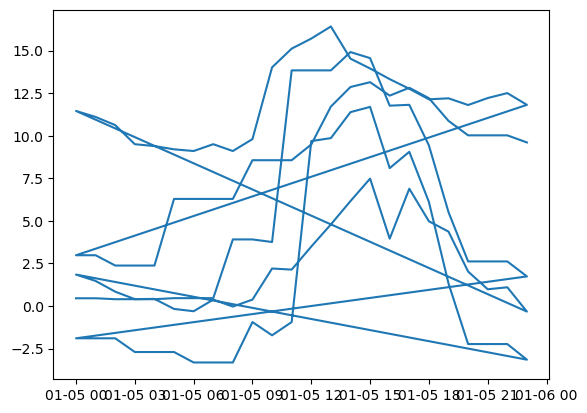

In [200]:
#Examine a particular day
wd_day = weather_data.loc['2015-01-05']
plt.plot(wd_day.index, wd_day['temp'])
plt.show()

There are five times the weather data because there is a data point for each of the five cities.

### 2.2 Investigate missing values in weather data<a id='2.2_Investigate_missing_values'></a>

In [201]:
#Analyze missing data in weather df
missing_weather = pd.concat([weather_data.isnull().sum(), 100 * weather_data.isnull().mean()], axis=1)
missing_weather.columns=['count', '%']
missing_weather.sort_values(by='count', ascending=False)

,count,%
city_name,0,0.0
temp,0,0.0
pressure,0,0.0
humidity,0,0.0
wind_speed,0,0.0
wind_deg,0,0.0
rain_1h,0,0.0
rain_3h,0,0.0
snow_3h,0,0.0
clouds_all,0,0.0


### 2.3 Investigate categorical features<a id='2.3_Investigate_categorical_features'></a>

In [202]:
#Candidates for categorical features are: weather_id, weather_main, weather_description, weather_icon
#Find unique values for each
id_unq = weather_data.weather_id.unique()
main_unq = weather_data.weather_main.unique()
desc_unq = weather_data.weather_description.unique()
icon_unq = weather_data.weather_icon.unique()
print(f"The number of unique weather_id values is {len(id_unq)}.")
print(f"The number of unique weather_main values is {len(main_unq)}.")
print(f"The number of unique weather_description values is {len(desc_unq)}.")
print(f"The number of unique weather_icon values is {len(icon_unq)}.")

The number of unique weather_id values is 38.
The number of unique weather_main values is 12.
The number of unique weather_description values is 43.
The number of unique weather_icon values is 24.


Due to the size of the number of unique values for each of these categories, and the fact that the course has not yet covered natural language processing, these features will be removed from the dataframe.

In [203]:
#Drop the weather_id, weather_main, weather_description, and weather_icon features
weather_data = weather_data.drop(columns = ["weather_id", "weather_main", "weather_description", "weather_icon"])

### 2.4 Summarizing the data<a id='2.4_Summarizing_the_data'></a>

In [205]:
#print(wea_grouped_max.columns)
weather_data.columns

Index(['city_name', 'temp', 'pressure', 'humidity', 'wind_speed', 'wind_deg',
       'rain_1h', 'rain_3h', 'snow_3h', 'clouds_all'],
      dtype='object')

In [206]:
#get a list of the column names you want to summarize (df.columns returns an Index object, when we need a list)
col_list = list(weather_data)
#get a list of only the columns you want to operate on
col_list.remove("city_name")

print(col_list)

['temp', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 'rain_1h', 'rain_3h', 'snow_3h', 'clouds_all']


In [207]:
wea_grouped_max = weather_data.groupby([weather_data.index.date, weather_data.city_name])[col_list].max()

col_list_new_names = [text + '_daily_max' for text in col_list]
wea_grouped_max.columns = [col_list_new_names]
wea_grouped_max.head(15)

temp_daily_max pressure_daily_max humidity_daily_max  \
           city_name                                                        
2015-01-01 Barcelona      11.452313               1038                100   
           Bilbao         11.441688               1036                 97   
           Madrid         10.158313               1036                 75   
           Seville        13.844000               1043                 84   
           Valencia       12.127344               1035                 84   
2015-01-02 Barcelona      13.178688               1039                100   
           Bilbao         11.695344               1038                 95   
           Madrid         11.795344               1038                 79   
           Seville        13.714313               1045                 89   
           Valencia       14.403688               1037                 82   
2015-01-03 Barcelona      13.998000               1037                100   
           Bilbao         11.659000               1037                 97   
           Madrid         12.587000               1036                 86   
           Seville        14.823000               1045                 90   
           Valencia       17.173000               1032                 80   

                     wind_speed_daily_max wind_deg_daily_max  \
           city_name                                           
2015-01-01 Barcelona                    7                353   
           Bilbao                       1                229   
           Madrid                       1                344   
           Seville                      4                 57   
           Valencia                     2                321   
2015-01-02 Barcelona                    2                338   
           Bilbao                       2                291   
           Madrid                       1                354   
           Seville                      4                 56   
           Valencia                     2                289   
2015-01-03 Barcelona                    3                328   
           Bilbao                       1                294   
           Madrid                       2                223   
           Seville                      3                 64   
           Valencia                     2                278   

                     rain_1h_daily_max rain_3h_daily_max snow_3h_daily_max  \
           city_name                                                         
2015-01-01 Barcelona               0.0               0.0               0.0   
           Bilbao                  0.0               0.0               0.0   
           Madrid                  0.0               0.0               0.0   
           Seville                 0.0               0.0               0.0   
           Valencia                0.0               0.0               0.0   
2015-01-02 Barcelona               0.0               0.0               0.0   
           Bilbao                  0.0               0.0               0.0   
           Madrid                  0.0               0.0               0.0   
           Seville                 0.0               0.0               0.0   
           Valencia                0.0               0.0               0.0   
2015-01-03 Barcelona               0.0               0.0               0.0   
           Bilbao                  0.0               0.0               0.0   
           Madrid                  0.0               0.0               0.0   
           Seville                 0.0               0.0               0.0   
           Valencia                0.0               0.0               0.0   

                     clouds_all_daily_max  
           city_name                       
2015-01-01 Barcelona                    0  
           Bilbao                      24  
           Madrid                       0  
           Seville                      0  
           Valencia            

In [208]:
#leave weather_data alone for now
#create a df without wind_deg b/c you don't want to use the "max" of that - not sure if this should be reintegrated in some way later?
wea_grouped_max = wea_grouped_max.drop(columns=['wind_deg_daily_max'])

C:\Users\keral\AppData\Local\Temp\ipykernel_18964\938931152.py:3: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  wea_grouped_max = wea_grouped_max.drop(columns=['wind_deg_daily_max'])


In [209]:
#name date index
wea_grouped_max.index.names = ['date', 'city_name']
wea_grouped_max.head(15)

temp_daily_max pressure_daily_max humidity_daily_max  \
date       city_name                                                        
2015-01-01 Barcelona      11.452313               1038                100   
           Bilbao         11.441688               1036                 97   
           Madrid         10.158313               1036                 75   
           Seville        13.844000               1043                 84   
           Valencia       12.127344               1035                 84   
2015-01-02 Barcelona      13.178688               1039                100   
           Bilbao         11.695344               1038                 95   
           Madrid         11.795344               1038                 79   
           Seville        13.714313               1045                 89   
           Valencia       14.403688               1037                 82   
2015-01-03 Barcelona      13.998000               1037                100   
           Bilbao         11.659000               1037                 97   
           Madrid         12.587000               1036                 86   
           Seville        14.823000               1045                 90   
           Valencia       17.173000               1032                 80   

                     wind_speed_daily_max rain_1h_daily_max rain_3h_daily_max  \
date       city_name                                                            
2015-01-01 Barcelona                    7               0.0               0.0   
           Bilbao                       1               0.0               0.0   
           Madrid                       1               0.0               0.0   
           Seville                      4               0.0               0.0   
           Valencia                     2               0.0               0.0   
2015-01-02 Barcelona                    2               0.0               0.0   
           Bilbao                       2               0.0               0.0   
           Madrid                       1               0.0               0.0   
           Seville                      4               0.0               0.0   
           Valencia                     2               0.0               0.0   
2015-01-03 Barcelona                    3               0.0               0.0   
           Bilbao                       1               0.0               0.0   
           Madrid                       2               0.0               0.0   
           Seville                      3               0.0               0.0   
           Valencia                     2               0.0               0.0   

                     snow_3h_daily_max clouds_all_daily_max  
date       city_name                                         
2015-01-01 Barcelona               0.0                    0  
           Bilbao                  0.0                   24  
           Madrid                  0.0                    0  
           Seville                 0.0                    0  
           Valencia                0.0                    0  
2015-01-02 Barcelona               0.0                   64  
           Bilbao                  0.0                   22  
           Madrid                  0.0                   32  
           Seville                 0.0                    0  
           Valencia                0.0                    0  
2015-01-03 Barcelona               0.0                   44  
           Bilbao                  0.0                   12  
           Madrid                  0.0                    4  
           Seville                 0.0                    0  
           Valencia                0.0                   12

In [210]:
# save the data to a new csv file
energy_data.to_csv('data/energy_data.csv')
weather_data.to_csv('data/weather_data.csv')
eng_grouped_max.to_csv('data/eng_grouped_max.csv')
wea_grouped_max.to_csv('data/wea_grouped_max.csv')

In [211]:
energy_data.to_pickle('data/energy_data.pkl')
weather_data.to_pickle('data/weather_data.pkl')
eng_grouped_max.to_pickle('data/eng_grouped_max.pkl')
wea_grouped_max.to_pickle('data/wea_grouped_max.pkl')

See "Capstone_02_joining" for continuation of notebooks.